<a href="https://colab.research.google.com/github/jb-chaudron/inet-vanilla/blob/main/Copie_de_syst_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Installation des paquets

In [ ]:
pip install mne

     |████████████████████████████████| 6.9MB 6.4MB/s 


In [ ]:
pip install permute

     |████████████████████████████████| 153kB 5.2MB/s 


In [ ]:
pip install powerlaw

  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24788 sha256=2669ff086c5f38706516eb3b8c692905b71819dce108baa5b8a4d3468debc0d4
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [ ]:
pip install cdlib

     |████████████████████████████████| 143kB 6.7MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 40.6MB 107kB/s 
     |████████████████████████████████| 1.8MB 39.0MB/s 
     |████████████████████████████████| 24.2MB 1.3MB/s 
  Created wheel for karateclub: filename=karateclub-1.0.22-cp36-none-any.whl size=93242 sha256=c8cf0cc189652e149aa5653b6eab20ac6c98b2199e57d7ed0fda29d251e6c270
  Stored in directory: /root/.cache/pip/wheels/60/ef/0a/b9f163e1bc2fa9337ef4b183529d09c2ea78588cbc2c3753ef
Successfully built karateclub
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import scipy.stats as sts
import random
from statsmodels.stats.multitest import multipletests
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install EMD-signal

     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 


In [ ]:
pip install cdlib

#2 - Preprocessing / Graph

#2.a - Ouverture du jeu de données

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Patient/epoch_p01_bipolaire_clean-epo.fif"

ep = mne.read_epochs(path)


Reading /content/drive/My Drive/Colab Notebooks/Patient/epoch_p01_bipolaire_clean-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 22 columns
Replacing existing metadata with 22 columns
498 matching events found
No baseline correction applied
0 projection items activated


#2.b - Potentiels évoqués -  FDR Graph 

In [ ]:
ep_succ = ep["error == 1.0"].copy().average().crop(tmin=0.05, tmax=0.15)
ep_err = ep["error == 0.0"].copy().average().crop(tmin=0.05,tmax=0.15)

In [ ]:
def hilb_10hz(lf,hf,data):
  for i in range(lf,hf,10):
    n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
    n_dat.apply_hilbert(n_jobs=1,envelope=True)
    if i == lf:
      out = n_dat.to_data_frame(index='time')
      out = out.apply(sts.zscore,axis=0)
      
    else:
      dat = n_dat.to_data_frame(index="time")
      dat = dat.apply(sts.zscore,axis=0)
      out = out + dat
      
      del dat
    del n_dat
  return out

In [ ]:
def graph(df,graph=1):
  G = nx.Graph()
  sig = {a : {} for a in df.columns}
  G.add_nodes_from(df.columns)
  pval = np.empty((len(df.columns),len(df.columns)),dtype=object)
  c = 0
  
  for i in df.columns:
    sig[i] = {x : sts.spearmanr(df[i],df[x]) for x in df.columns}
    pval[c,:] = [sig[i][x][1] for x in sig[i].keys()]
    c+=1
  
  pval = np.reshape(pval,(len(df.columns)*(len(df.columns))))
  a = multipletests(pval,alpha=0.01,method='holm')
  b = np.reshape(a[0],(len(df.columns),len(df.columns)))
  if graph == 1:
    for i in range(len(df.columns)):
      add = [df.columns[x] for x in range(len(df.columns)) if b[i][x]]
      
      if len(add) == 0:
        pass
      else:
        G.add_edges_from([(df.columns[i],x,{"weight" :abs(sig[df.columns[i]][x][0])}) for x in add if not df.columns[i]==x])
    return G
  else:
    return np.reshape(a[1],(len(df.columns),len(df.columns))),sig

In [ ]:
ep_succ = hilb_10hz(80,120,ep_succ)
ep_err = hilb_10hz(80,120,ep_err)

Setting up band-pass filter from 80 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 169 samples (0.165 sec)

Setting up band-pass filter from 90 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 90.00
- Lower transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency:

<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (169) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (151) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 137 samples (0.134 sec)

Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB

<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (137) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (123) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (169) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 90 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 90.00
- Lower transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 151 samples (0.147 sec)

Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff 

<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (151) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (137) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
<ipython-input-10-720d2cad2942>:3: RuntimeWarning: filter_length (123) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


In [ ]:
g_err = graph(ep_err)
g_succ = graph(ep_succ)

In [ ]:
g_err.edges

EdgeView([("tp'1-tp'2", "tp'5-tp'6"), ("tp'1-tp'2", "tp'6-tp'7"), ("tp'1-tp'2", "tp'8-tp'9"), ("tp'1-tp'2", "tb'4-tb'5"), ("tp'1-tp'2", "tb'8-tb'9"), ("tp'1-tp'2", "tb'9-tb'10"), ("tp'1-tp'2", "a'6-a'7"), ("tp'1-tp'2", "a'7-a'8"), ("tp'1-tp'2", "a'8-a'9"), ("tp'1-tp'2", "b'8-b'9"), ("tp'1-tp'2", "gph'4-gph'5"), ("tp'1-tp'2", "gph'9-gph'10"), ("tp'1-tp'2", "t'1-t'2"), ("tp'1-tp'2", "h'1-h'2"), ("tp'1-tp'2", "h'2-h'3"), ("tp'1-tp'2", "h'3-h'4"), ("tp'1-tp'2", "or'2-or'3"), ("tp'1-tp'2", "or'3-or'4"), ("tp'1-tp'2", "or'5-or'6"), ("tp'1-tp'2", "or'8-or'9"), ("tp'1-tp'2", "or'9-or'10"), ("tp'1-tp'2", "of'1-of'2"), ("tp'1-tp'2", "of'4-of'5"), ("tp'1-tp'2", "of'12-of'13"), ("tp'1-tp'2", "of'13-of'14"), ("tp'1-tp'2", "ia'2-ia'3"), ("tp'1-tp'2", "ia'3-ia'4"), ("tp'1-tp'2", "ia'10-ia'11"), ("tp'1-tp'2", "ip'2-ip'3"), ("tp'1-tp'2", "ip'4-ip'5"), ("tp'1-tp'2", "ip'5-ip'6"), ("tp'1-tp'2", "pi'11-pi'12"), ("tp'1-tp'2", "pi'13-pi'14"), ("tp'1-tp'2", 'tb1-tb2'), ("tp'1-tp'2", 'tb2-tb3'), ("tp'1-tp'2",

#2.c Network Based Statistic Graph

In [ ]:
def hilbraw_10hz(lf,hf,data):
  for i in range(lf,hf,10):
    n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')
    n_dat.apply_hilbert(n_jobs=1,envelope=True)
    if i == lf:
      out = n_dat.get_data()
      out = sts.zscore(out,axis=2)

    else:
      dat = n_dat.get_data()
      dat = sts.zscore(dat,axis=2)
      out = out + dat

      del dat
    del n_dat
  return out

In [ ]:
def perm(d1,d2,l=100):
  m1 = random.choices(range(np.shape(d1)[0]),k=l)
  m2 = random.choices(range(np.shape(d2)[0]),k=l)
  m3 = np.concatenate((d1[m1,:,:],d2[m2,:,:]),axis=0)
  m3 = np.mean(m3,axis=0) #shape(n_contact,n_ms)
  print(np.shape(m3))
  return m3

Deux version du NBS, l'une prenant en compte les p-values corrigées, l'autre la corrélation

In [ ]:
def NBS(d1,d2,con,df1,df2,k=100):
  pper = np.empty((len(con),len(con),k),dtype=np.float64)
  
  
  for j in range(k):
    per = perm(d1,d2,100)
    sig = {a : {} for a in con}
    pval = np.empty((len(con),len(con)),dtype=object)
    c = 0
    for i in range(np.shape(per)[0]):
      sig[con[i]] = {con[x] : sts.spearmanr(per[i],per[x]) for x in range(len(con))}
      pval[c,:] = [sig[con[i]][x][1] for x in sig[con[i]].keys()]
      c+=1
    pval = np.reshape(pval,(len(con)*(len(con))))
    a = multipletests(pval,alpha=0.01,method='holm')
    pper[:,:,j] = np.reshape(a[1],(len(con),len(con)))
    print(j)
  
  g1,sig1 = graph(df1,graph=0) #shape(n_contact,n_contact)
  G1 = nx.Graph()
  for i in range(len(con)):
    print([np.sort(pper[i,x,:])[math.ceil(0.05*k)] for x in range(len(con))])
    add = [con[x] for x in range(len(con)) if g1[i][x] > np.sort(pper[i,x,:])[math.ceil(0.05*k)]]
    if len(add) == 0:
      pass
    else:
      G1.add_edges_from([(con[i],x,{"weight" :abs(sig[con[i]][x][0])}) for x in add if not con[i]==x])
  
  g2,sig2 = graph(df2,graph=0)
  G2 = nx.Graph()
  for i in range(len(con)):
    #print("G2 = ",g2[1][1])
    #print("pval = ",np.sort(pper[1,1,:])[math.ceil(0.05*k)])
    add = [con[x] for x in range(len(con)) if g2[i][x] > np.sort(pper[i,x,:])[math.ceil(0.05*k)]]
    if len(add) == 0:
      pass
    else:
      G1.add_edges_from([(con[i],x,{"weight" :abs(sig[con[i]][x][0])}) for x in add if not con[i]==x])
  
  return G1,G2

In [ ]:
def NBSS(d1,d2,con,df1,df2,k=100):
  pper = np.empty((len(con),len(con),k),dtype=np.float64)
  
  #%%%% On calcul les statistiques des différentes permutations
  for j in range(k):
    #1) On fait une permutation
    per = perm(d1,d2,100)

    #2) On construit un dictionnaire pour y inclure les résultats de spearman
    sig = {a : {} for a in con}
    pval = np.empty((len(con),len(con)),dtype=object) #Artéfact des différentes forme, à rejeter si pas besoin
    c = 0

    #3) Pour chaque contact, on attribue un score de corrélation pour cette permutation
    pper[:,:,j] = np.absolute(sts.spearmanr(per,axis=1)[0])
    """
    for i in range(np.shape(per)[0]):
      sig[con[i]] = {con[x] : sts.spearmanr(per[i],per[x]) for x in range(len(con))}
      pper[c,:,j] = [abs(sig[con[i]][x][0]) for x in sig[con[i]].keys()]
      c+=1
    """
  #%%%% On calcul la NBS pour le graph de la condition 1
  #1) On calcul la correlation de spearman pour les données du graph 1
  g1,sig1 = graph(df1,graph=0) #shape(n_contact,n_contact)
  G1 = nx.Graph()

  #2) On compare la force de la correlation à celle des permutations
  for i in range(len(con)):
    add = [con[x] for x in range(len(con)) if abs(sig1[con[i]][con[x]][0]) > np.sort(pper[i,x,:])[math.floor(0.95*k)]]
    if len(add) == 0:
      pass
    else:
      G1.add_edges_from([(con[i],x,{"weight" :abs(sig1[con[i]][x][0])}) for x in add if not con[i]==x])

  #%%%% On calcul la NBS pour le graph de la condition 2
  g2,sig2 = graph(df2,graph=0)
  G2 = nx.Graph()
  for i in range(len(con)):
    add = [con[x] for x in range(len(con)) if abs(sig2[con[i]][con[x]][0]) > np.sort(pper[i,x,:])[math.floor(0.95*k)]]
    if len(add) == 0:
      pass
    else:
      G2.add_edges_from([(con[i],x,{"weight" :abs(sig2[con[i]][x][0])}) for x in add if not con[i]==x])
  cut = np.array([[np.sort(pper[i,x,:])[math.floor(0.95*k)] for i in range(len(con))]for x in range(len(con))])
  return G1,G2,cut

In [ ]:
epraw_succ = ep["error == 1.0"].copy().crop(tmin=0.05, tmax=0.15)
epraw_err = ep["error == 0.0"].copy().crop(tmin=0.05,tmax=0.15)

In [ ]:
epraw_succ = hilbraw_10hz(80,120,epraw_succ)
epraw_err = hilbraw_10hz(80,120,epraw_err)

Setting up band-pass filter from 80 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 169 samples (0.165 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (169) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 90 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 90.00
- Lower transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 151 samples (0.147 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (151) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 137 samples (0.134 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (137) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 123 samples (0.120 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (123) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 80 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 169 samples (0.165 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (169) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 90 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 90.00
- Lower transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 151 samples (0.147 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (151) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 137 samples (0.134 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (137) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 123 samples (0.120 sec)



<ipython-input-15-a3c2cadc9212>:3: RuntimeWarning: filter_length (123) is longer than the signal (104), distortion is likely. Reduce filter length or filter a longer signal.
  n_dat = data.copy().filter(l_freq=i,h_freq=i+10,n_jobs=1,fir_design='firwin')


In [ ]:
nbg_err,nbg_succ,cutoff = NBSS(epraw_err,epraw_succ,ep.info["ch_names"],ep_err,ep_succ,k=20)

(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)
(122, 104)


#3 Analyse des graphs

#3.a - Description des Graphs

Nb Noeuds +
Nb Liens

In [ ]:
def desc_taille(graph):
  for c in nx.connected_components(graph):
    print("Nb noeuds = ",len(graph.subgraph(c).number_of_nodes()))
    print("Nb liens = ",len(graph.subgraph(c).number_of_edges()))

Clustering Coefficient + Densité

In [ ]:
def desc_cc_dens(graph,w=False):
  for c in nx.connected_components(graph):
    if w:  
      print("Clustering Coefficient : ",nx.clustering(graph.subgraph(c),weight="weight"))
    else:
      print("Clustering Coefficient : ",nx.clustering(graph.subgraph(c)))
    print("Densité : ",nx.density(c))

Av Path Length + Diamètre

In [ ]:
def desc_pl_diam(graph,w=False):
  for c in nx.connected_components(graph):
    if w:
      print("Average path length : ",nx.average_shortest_path_lentgh(c,weight="weight"))
      print("Diamètre : ",nx.diameter(c,weight="weight"))
    else:
      print("Average path length : ",nx.average_shortest_path_lentgh(c))
      print("Diamètre : ",nx.diameter(c))

[40, 44, 63, 54, 40, 42, 62, 12, 46, 24, 37, 41, 53, 35, 32, 43, 23, 39, 43, 50, 41, 51, 30, 47, 48, 49, 36, 61, 57, 42, 53, 48, 31, 57, 34, 47, 32, 47, 59, 48, 30, 32, 37, 61, 43, 44, 30, 25, 28, 28, 39, 53, 47, 27, 51, 45, 46, 32, 28, 37, 39, 54, 49, 31, 32, 19, 57, 31, 29, 53, 38, 47, 38, 42, 37, 48, 44, 31, 20, 43, 53, 44, 36, 38, 33, 51, 27, 30, 15, 40, 44, 38, 24, 61, 52, 47, 34, 46, 45, 28, 31, 44, 52, 37, 44, 38, 46, 37, 54, 43, 36, 47, 42, 35, 48, 33, 53, 45, 44, 52, 42, 45]


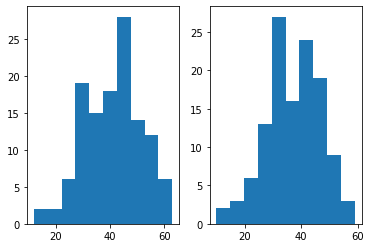

42.0
38.0


'\nprint([x for x in g_err.nodes])\nprint(nx.average_clustering(g_err))\nprint(nx.average_clustering(g_succ))\nfor C in nx.connected_components(g_succ):\n    print(len(C))\n\n\n\nprint(nx.average_shortest_path_length(g_err,weight="weight"))\nprint(nx.average_shortest_path_length(g_err,weight=None))\nprint(nx.average_shortest_path_length(g_succ,weight="weight"))\nprint(nx.average_shortest_path_length(g_succ,weight=None))\n'

In [ ]:
import scipy.stats as sts
e_deg = [x[1] for x in g_err.degree]
s_deg = [x[1] for x in g_succ.degree]
print(e_deg)
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.hist(e_deg)
ax2.hist(s_deg)
plt.show()
print(np.median(e_deg))
print(np.median(s_deg))
"""
print([x for x in g_err.nodes])
print(nx.average_clustering(g_err))
print(nx.average_clustering(g_succ))
for C in nx.connected_components(g_succ):
    print(len(C))



print(nx.average_shortest_path_length(g_err,weight="weight"))
print(nx.average_shortest_path_length(g_err,weight=None))
print(nx.average_shortest_path_length(g_succ,weight="weight"))
print(nx.average_shortest_path_length(g_succ,weight=None))
"""

In [ ]:
bt = nx.pagerank(g_err,weight='weight')
nx.set_node_attributes(g_err,bt,"rank")
h_bt_err = sorted(bt.keys(),key=lambda x: bt[x],reverse=True)[:20]
l_bt_err = sorted(bt.keys(),key=lambda x: bt[x])[:20]

print(h_bt_err[:20])
print(l_bt_err[:20])

["tp'6-tp'7", "ip'13-ip'14", "tb'4-tb'5", "t'7-t'8", "b'10-b'11", "h'5-h'6", "of'6-of'7", "b'11-b'12", "gph'7-gph'8", "or'4-or'5", "tb'10-tb'11", 'h1-h2', "tp'7-tp'8", 'b2-b3', "of'9-of'10", "of'1-of'2", 'b10-b11', "pi'14-pi'15", "pi'1-pi'2", "b'4-b'5"]
["tb'5-tb'6", "ip'3-ip'4", "ia'5-ia'6", "of'5-of'6", "a'4-a'5", "ip'12-ip'13", "h'11-h'12", "or'6-or'7", "ip'1-ip'2", "or'2-or'3", "or'11-or'12", "of'8-of'9", "tb'7-tb'8", "b'5-b'6", "or'1-or'2", "h'10-h'11", "h'2-h'3", "pi'11-pi'12", "of'4-of'5", "of'7-of'8"]


In [ ]:
bt = nx.pagerank(g_succ,weight='weight')
nx.set_node_attributes(g_succ,bt,"rank")
h_bt_succ = sorted(bt.keys(),key=lambda x: bt[x],reverse=True)[:20]
l_bt_succ = sorted(bt.keys(),key=lambda x: bt[x])[:20]

print(h_bt_succ[:20])
print(l_bt_succ[:20])

diff_h = set(h_bt_succ).intersection(set(h_bt_err))
diff_l = set(l_bt_err).intersection(set(l_bt_err))

print(diff_h)
print(diff_l)

["gph'9-gph'10", "a'7-a'8", "b'6-b'7", "ip'5-ip'6", "pi'9-pi'10", "b'5-b'6", "tp'1-tp'2", "ia'10-ia'11", "pi'10-pi'11", 'b11-b12', 'tb9-tb10', "ip'4-ip'5", "or'13-or'14", "t'2-t'3", "t'7-t'8", 'tb1-tb2', "pi'12-pi'13", 'b8-b9', "tb'7-tb'8", "or'9-or'10"]
["pi'13-pi'14", 'b5-b6', "b'12-b'13", "t'1-t'2", 'b2-b3', "of'9-of'10", "of'4-of'5", "tp'5-tp'6", "ia'2-ia'3", "tb'8-tb'9", 'b4-b5', 'h8-h9', "ip'12-ip'13", "or'2-or'3", "tb'5-tb'6", "b'7-b'8", "tb'6-tb'7", "h'4-h'5", "ip'11-ip'12", "gph'6-gph'7"]
{"t'7-t'8"}
{"ip'3-ip'4", "ip'1-ip'2", "of'5-of'6", "or'6-or'7", "ip'12-ip'13", "of'7-of'8", "or'1-or'2", "pi'11-pi'12", "b'5-b'6", "tb'5-tb'6", "of'4-of'5", "a'4-a'5", "h'10-h'11", "or'11-or'12", "or'2-or'3", "of'8-of'9", "h'2-h'3", "ia'5-ia'6", "tb'7-tb'8", "h'11-h'12"}


#3.b Centralité

Betweenness

In [ ]:
ct = nx.betweenness_centrality()

TypeError: ignored

Harmonic Centrality

In [ ]:
ct = nx.harmonic_centrality()

TypeError: ignored

Katz

In [ ]:
ct = nx.katz_centrality()

PageRank

In [ ]:
ct = nx.pagerank()

Jaccard Coefficient des X meilleurs ou plus mauvais noeud selon les métriques

In [ ]:
def jaccard(G,func,w=False,n=20,bout="h"):
  """
    G : Une liste de graphs
    func : La fonction de centralité que l'on souhaite utiliser
    w : Les liens sont pondérés ou non
    n : Le nombre de noeuds que l'on veut considéré pour voir s'il y a une différence entre les réseaux
    bout : Est ce qu'on veut les "n" noeuds avec la plus petite "b" ou plus grande centralité "h" ?
  """

  #On détermine les noms des composants que l'on va comparer
  #Le premier graph s'appellera G1_s1, si il a plusieurs sous graph il aura d'autres noms G1_s2, G1_s3 etc...
  #Les autres graphs seront G2_s1,G3_s1 etc... avec s2, s3 etc... si il y a des sous composants chez eux aussi
  lab = reduce(lambda a,b: a+b,[["G"+str(i+1)+"_s"+str(j+1) for j in range(len(nx.connected_components(G[i])))] for i in range(len(G))])
  df = pd.DataFrame(index=lab,columns=lab)

  #On détermine si on triera dans l'ordre ascendant ou descendant
  if bout == "h":
    bout = True
  else:
    bout = False

  ct = []
  d = 0
  for i in G:
    for c in nx.connected_components(i):
      if w:
        central = func(i.subgraph(c),weight="weight")
      else:
        central = func(i.subgraph(c))
      ct[d] += [set(sorted(central.keys(),reverse=bout,key=lambda a: central[a])[:n])]
      d += 1

  for i,j in itr.product(range(len(ct)),range(len(ct))):
    df.iloc[i,j] = len(ct[i].intersection(ct[j]))/len(ct[i].union(ct[j]))
  return df

#3.c - Random Network / Power Law / Degree distribution

Degree Distribution

In [ ]:
def deg(G):
  d = [x[1] for x in G.degree]
  plt.hist(d)
  plt.show()

Power Law

In [ ]:
import powerlaw
def PL(G):
  data = [x[1] for x in G.degree]
  results = powerlaw.Fit(data)
  print("Alpha = ",results.power_law.alpha)
  print("Xmin = ",results.power_law.xmin)
  R, p = results.distribution_compare('power_law', 'lognormal')

  print("p_val Kolmogorov = ",results.power_law.KS(data))
  return results

In [ ]:
a = PL(nbg_err)

Alpha =  4.55716315791209
Xmin =  6.0
p_val Kolmogorov =  0.10209114846342121


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [ ]:
#On peut évaluer à quel point une distribution d'un graph fit avec les données d'un autre
#p.ex.
f_err = PL(g_err)
f_succ = PL(g_succ)
#Test pour savoir à quel point la distribution des degrés du réseau des succès décrit la distribution des dégrés des erreurs
print("KS succ -> err = ",f_succ.power_law.KS([x[1] for x in g_err.degree]))

Alpha =  8.93135971114567
Xmin =  44.0
p_val Kolmogorov =  0.12629270996716768
Alpha =  49.85873662740003
Xmin =  54.0
p_val Kolmogorov =  0.12964484355853267
KS succ -> err =  0.12964484355853267


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


#3.d Détection de Communautés

Classique Louvain

In [ ]:
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters

In [ ]:
def lou(G,pos):
  louv_clust = louvain(G,weight='weight')

  ## 1.c : Noter les communautés sur le graph de base
  com = louv_clust.to_node_community_map()
  nx.set_node_attributes(G,com,"community")

  ## 1.d : Visualiser les communautées
  #pos = nx.drawing.layout.spring_layout(g_err)
  plot_network_clusters(G, louv_clust, pos)
  plt.show()

In [ ]:
pos = nx.drawing.layout.spring_layout(g_err)
for i in g_ep_su:
  for j in nx.connected_components(i):
    print(len(j))

In [ ]:
print(nbg_err.nodes.data(data="community"))
print("coucou",np.unique([x[1][0] for x in nbg_err.nodes.data(data="community") if not x[1] is None]))
pos = nx.drawing.layout.spring_layout(g_err)
lou(g_ep_er,pos)
lou(nbg_succ,pos)

[("tp'1-tp'2", None), ("t'1-t'2", None), ("h'1-h'2", None), ("ia'2-ia'3", None), ("tp'5-tp'6", None), ("tp'6-tp'7", None), ("tp'8-tp'9", None), ("tb'4-tb'5", None), ("pi'10-pi'11", None), ("tp'7-tp'8", None), ("or'4-or'5", None), ("ip'13-ip'14", None), ("pi'14-pi'15", None), ("tb'8-tb'9", None), ("tb'3-tb'4", None), ("of'7-of'8", None), ("gph'4-gph'5", None), ("t'7-t'8", None), ("of'13-of'14", None), ('tb2-tb3', None), ("tb'6-tb'7", None), ("pi'2-pi'3", None), ('b4-b5', None), ("tb'7-tb'8", None), ("b'12-b'13", None), ("or'2-or'3", None), ("ia'1-ia'2", None), ("ip'2-ip'3", None), ("ip'3-ip'4", None), ("or'9-or'10", None), ("or'10-or'11", None), ("of'12-of'13", None), ("ia'10-ia'11", None), ('tb9-tb10', None), ("tb'9-tb'10", None), ("a'4-a'5", None), ("a'7-a'8", None), ("gph'9-gph'10", None), ('b3-b4', None), ('b11-b12', None), ("tb'10-tb'11", None), ("h'5-h'6", None), ("tb'11-tb'12", None), ("gph'6-gph'7", None), ("or'8-or'9", None), ("or'12-or'13", None), ("a'3-a'4", None), ("t'2-t'3"

AttributeError: ignored

In [ ]:
def clus_diff(G1,G2):
  #On récolte le nombre de communautée dans chaque graph
  c1 = np.unique([x[1][0] for x in G1.nodes.data(data="community")]) 
  c2 = np.unique([x[1][0] for x in G2.nodes.data(data="community")])

  #On créer 2 dataframe, pour montrer à quel point une communauté est inclue dans une autre
  df1 = pd.DataFrame(index=c1,columns=c2)
  df2 = pd.DataFrame(index=c2,columns=c1)

  #On calcul les coef qui valent nb_noeud_communs/nb_noeud_community
  for i in c1:
    df1.loc[i,:] = [len(set([x[0] for x in G1.nodes.data(data="community") if x[1][0] == i]).intersection(set([y[0] for y in G2.nodes.data(data="community") if y[1][0]==j])))/len(set([z[0] for z in G1.nodes.data(data="community") if z[1][0] == i])) for j in c2]
    df2.loc[:,i] = [len(set([x[0] for x in G1.nodes.data(data="community") if x[1][0] == i]).intersection(set([y[0] for y in G2.nodes.data(data="community") if y[1][0]==j])))/len(set([z[0] for z in G2.nodes.data(data="community") if z[1][0] == j])) for j in c2]

  return df1.astype(float),df2.astype(float)


Plot les dataframes

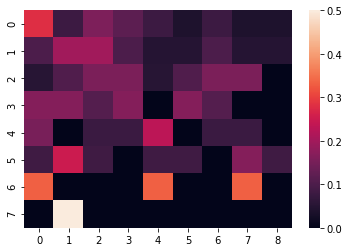

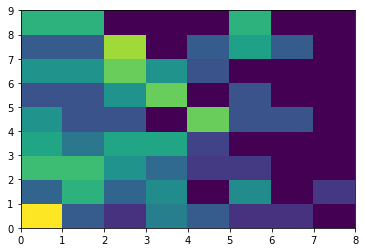

In [ ]:
d_err = d_err.astype(float)
d_succ= d_succ.astype(float)

import seaborn as sns
sns.heatmap(d_err)

plt.show()

plt.pcolor(d_succ)
plt.show()


#3.e Détection hierarchique de communauté et autres trucs

In [ ]:
#walker = random.choices(g_err.nodes,k=100)
def walk(g,W=100,l=1000):
  import random

  g_new = [g.subgraph(c) for c in nx.connected_components(g) if len(c) > 10]
  if len(g_new) == 1:
    g_new = g_new[0]
  elif len(g_new) == 2:
    g_new = nx.compose(g_new[0],g_new[1])
  else:
    g_new = nx.compose(g_new)

  walker = np.empty((W,l),dtype=object)
  walk_hz = np.empty((W,l),dtype=np.int64)
  walker[:,0] = random.choices([x for x in g_new.nodes()],k=W)

  for i in range(1,l):
    walker[:,i] = [random.choice([x for x in g_new[walker[j,i-1]]]) for j in range(len(walker[:,0]))]

  for i in range(np.shape(walker)[1]):
    b = np.unique(walker[:,i],return_counts=True)
    walk_hz[:,i] = [b[1][np.where(b[0]==x)[0]][0] for x in walker[:,i]]

  return walker,walk_hz

In [ ]:
def zerocross(data,label,uniq):
  llabel = uniq
  grp = []
  s = 0
  n=-1
  c = 0
  for i in data:
    if s == 0:
      grp += [[]]
      n0 = i
      n+=1
      grp[n] += [label[c]]
      c+=1
      s=1
    elif not (i<=0 and n0>=0) or (i>=0 and n0<=0):
      grp[n] += [label[c]]
      n0=i
      c+=1
    else:
      grp += [[]]
      n0 = i
      n+=1
      grp[n] += [label[c]]
      c+=1
  out = np.empty((len(grp),len(llabel)),dtype='bool')
  for i in range(len(grp)):
    out[i,:] = [1 if x in grp[i] else 0 for x in llabel]
  
  return out


ez
8


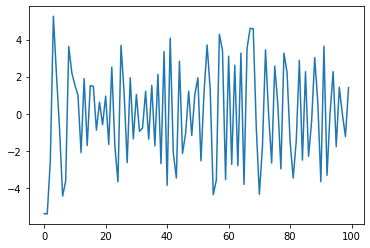

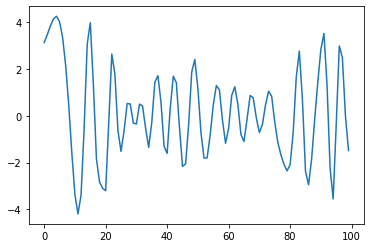

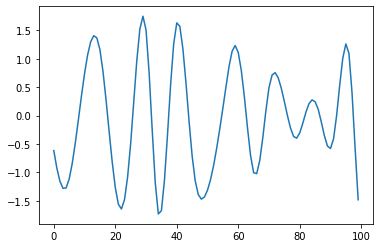

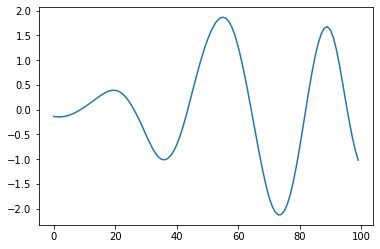

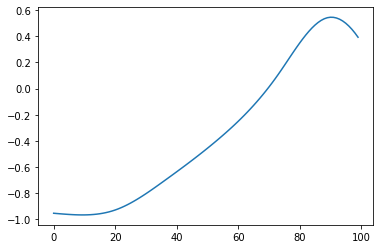

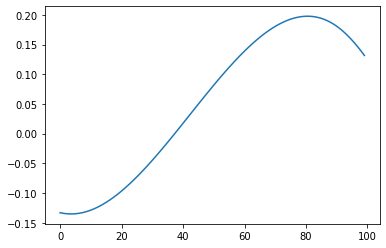

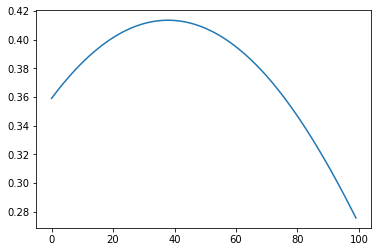

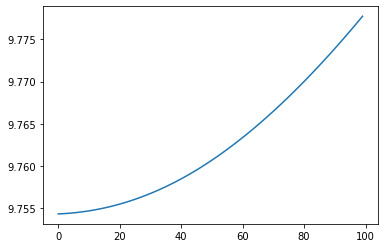

'\nfor i in range(np.shape(bli)[0])\n  for j in range(np.shape(bli)[1]):\n'

In [ ]:
from PyEMD import EMD
bla,bli = walk(g_err,W=1000,l=1000)
#bla[:,:,1] = bla[:,:,1].astype(np.int64,copy=False)
"""
print(type(bla[0,0,1]))
print([type(x) for x in bla[0,:,1] if (type(x) != type(bla[0,0,1]) or x == np.nan) ])
print([type(x) for x in bla[0,:,0]])
print(bla[0,:,1].dtype)

if np.isnan([x for x in bla[0,:,1]]).any():
  print("ok")
else:
  print("non nan")
plt.plot(bla[0,:100,1])
plt.show()
"""


"""
for i in range(np.shape(bli)[0])
  for j in range(np.shape(bli)[1]):
"""

In [ ]:
imf = np.empty((1000,4,1000),dtype=np.float64)
print("ez")
emd = EMD()
for i in range(np.shape(imf)[0]):
  imf[i,:,:] = emd.emd(bli[i,:])[:4]


ez


In [ ]:
lab = g_err.nodes()
imf1 = [zerocross(imf[i,0,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf1 = np.concatenate(imf1,axis=0)
imf2 = [zerocross(imf[i,1,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf2 = np.concatenate(imf2,axis=0)
imf3 = [zerocross(imf[i,2,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf3 = np.concatenate(imf3,axis=0)
imf4 = [zerocross(imf[i,3,:],bla[i,:],lab) for i in range(np.shape(imf)[0])]
imf4 = np.concatenate(imf4,axis=0)

Exploration des subgraph

In [ ]:
print([x[1] for x in g_err.nodes.data(data="rank")])

[0.0035798525738144674, 0.006164596179196885, 0.008180424997460183, 0.007523385524463438, 0.005022922979177967, 0.009258706322718071, 0.009423678521221567, 0.010287490580979185, 0.0076478364433642965, 0.010622568231669832, 0.01061969187780454, 0.008689361758445438, 0.008464745157771339, 0.004147709058578094, 0.00594690709665519, 0.008798689525476872, 0.006890506580444538, 0.010190007327993215, 0.011095431449902203, 0.00526816425091491, 0.00730775583000668, 0.0076412888384230025, 0.010823604495220475, 0.008754807170139664, 0.0033157170892954614, 0.008772003854378724, 0.006095033787469, 0.010766590873817369, 0.010435275150367922, 0.010603967857238626, 0.007265417436706678, 0.010030256715996496, 0.007455241191091552, 0.01086929853952004, 0.004867227407151762, 0.0052766430981742544, 0.004836881261677175, 0.006577399259212418, 0.010685655588633233, 0.004998227242732782, 0.010550742290269638, 0.009440053486401926, 0.00933208777621132, 0.0069988679940155805, 0.009126798755640021, 0.0085484269

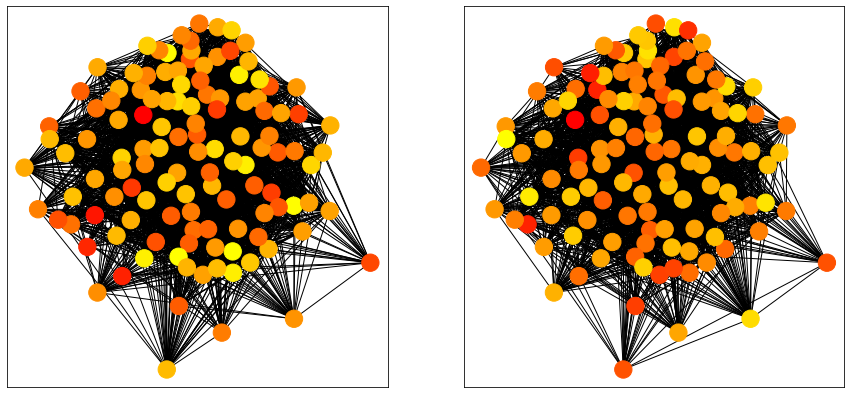

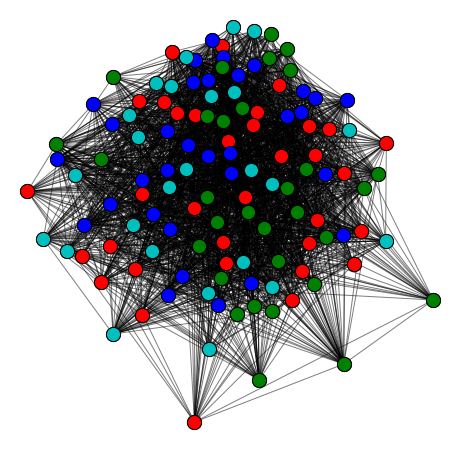

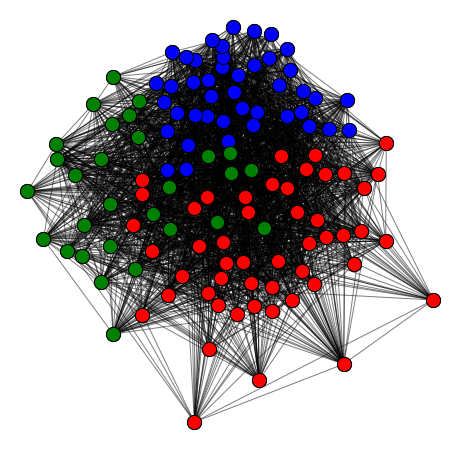

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,7))

nx.draw_networkx(g_err,pos=pos,ax=ax1,with_labels=False,node_color=[x[1] for x in g_err.nodes.data(data="rank")],cmap="autumn")
nx.draw_networkx(g_succ,pos=pos,ax=ax2,with_labels=False,node_color=[x[1] for x in g_succ.nodes.data(data="rank")],cmap="autumn")

plt.show()
plot_network_clusters(g_succ, louv_clust_succ, pos)
plt.show()
plot_network_clusters(g_succ, louv_clust_err, pos)

In [ ]:
!{sys.executable} -m pip install python-igraph

/bin/bash: {sys.executable}: command not found


In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Executing: /tmp/apt-key-gpghome.LGbiAZ0kfE/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Relea

In [ ]:
from graph_tool.all import *

g = collection.data["celegansneural"]
state = minimize_nested_blockmodel_dl(g)

state.draw()

In [ ]:
from cdlib import algorithms
from cdlib.viz import plot_network_clusters

#louv_clust_succ = louvain(g_succ,weight='weight')
inf = algorithms.angel(g_succ,min_community_size=5,threshold=0.25)
"""
## 1.c : Noter les communautés sur le graph de base
com = louv_clust.to_node_community_map()
nx.set_node_attributes(g_succ,com,"community")
"""
## 1.d : Visualiser les communautées
pos = nx.drawing.layout.spring_layout(g_succ)
plot_network_clusters(g_succ, inf, pos)
plt.show()

ModuleNotFoundError: ignored

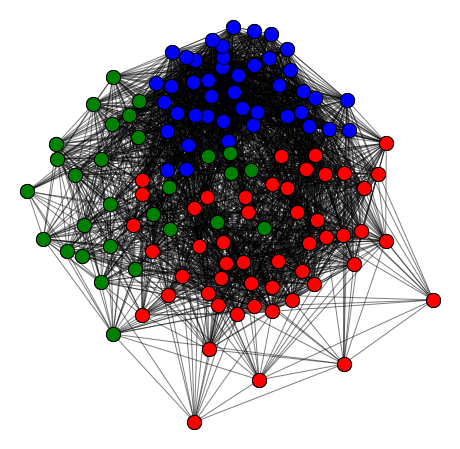

In [ ]:
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters
louv_clust_err = louvain(g_err,weight='weight')

## 1.c : Noter les communautés sur le graph de base
com = louv_clust.to_node_community_map()
nx.set_node_attributes(g_err,com,"community")

## 1.d : Visualiser les communautées
#pos = nx.drawing.layout.spring_layout(g_err)
plot_network_clusters(g_err, louv_clust_err, pos)
plt.show()

In [ ]:
print([x for x in g_err.nodes() if g_err.nodes[x]["community"] == [0]])
a = [g_succ.nodes[x]["community"] for x in g_succ.nodes() if g_err.nodes[x]["community"]== [0]]
c_0 = sts.mode(a)[0][0]
l_0 = [x for x in g_succ.nodes() if g_succ.nodes[x]["community"] == c_0]
print(len([x for x in g_err.nodes() if x in l_0 and g_err.nodes[x]["community"]==[0]])/len(l_0))
print(l_0)
print(a)
print(c_0)
co_err = [g_err.nodes[x]["community"][0] for x in g_err.nodes()]
co_succ = [g_succ.nodes[x]["community"][0] for x in g_succ.nodes()]
int_err = set([x for x in co_err if sum([1 if y==x else 0 for y in co_err]) > 5])
int_succ = set([x for x in co_succ if sum([1 if y==x else 0 for y in co_succ]) > 5])
print(max(co_err))
print(max(co_succ))
print(int_err)
print(int_succ)

["tp'1-tp'2", "tp'5-tp'6", "tp'6-tp'7", "tp'7-tp'8", "tb'4-tb'5", "tb'6-tb'7", "tb'9-tb'10", "tb'11-tb'12", "a'8-a'9", "b'4-b'5", "b'6-b'7", "b'7-b'8", "b'8-b'9", "b'9-b'10", "b'11-b'12", "gph'6-gph'7", "h'5-h'6", "h'10-h'11", "h'11-h'12", "or'1-or'2", "or'2-or'3", "or'5-or'6", "or'8-or'9", "or'9-or'10", "or'10-or'11", "or'13-or'14", "of'1-of'2", "of'4-of'5", "of'6-of'7", "of'7-of'8", "of'8-of'9", "of'9-of'10", "of'12-of'13", "of'13-of'14", "ia'1-ia'2", "ia'2-ia'3", "ia'4-ia'5", "ia'5-ia'6", "ia'6-ia'7", "ip'13-ip'14", "pi'2-pi'3", "pi'8-pi'9", "pi'11-pi'12", 'tb9-tb10', 'b1-b2', 'b3-b4', 'b7-b8', 'b8-b9', 'b9-b10', 'b10-b11']
0.5806451612903226
["tp'1-tp'2", "tp'5-tp'6", "tp'7-tp'8", "tb'6-tb'7", "tb'7-tb'8", "tb'11-tb'12", "tb'12-tb'13", "a'3-a'4", "b'8-b'9", "b'11-b'12", "gph'5-gph'6", "gph'8-gph'9", "h'4-h'5", "or'1-or'2", "or'2-or'3", "or'4-or'5", "or'5-or'6", "or'7-or'8", "or'9-or'10", "or'10-or'11", "of'6-of'7", "of'7-of'8", "of'12-of'13", "ia'2-ia'3", "ia'6-ia'7", "ip'1-ip'2", 

Pour identifier quelles communautées pourraient se rapprocher de l'autre

In [ ]:
dic_err = {x : [] for x in int_err}
dic_succ = {x : [] for x in int_succ}
for i in int_err:
  for j in int_succ:
    dic_err[i] += [len([x for x in g_err.nodes() if (g_err.nodes[x]["community"][0] == i) and (g_succ.nodes[x]["community"][0]==j)])/len([x for x in g_succ.nodes if g_succ.nodes[x]["community"][0]==j])]
    dic_succ[j] += [len([x for x in g_succ.nodes() if (g_succ.nodes[x]["community"][0] == j) and (g_err.nodes[x]["community"][0]==i)])/len([x for x in g_err.nodes if g_err.nodes[x]["community"][0]==i])]
print(dic_succ)
print(dic_err)

{0: [0.34, 0.2558139534883721, 0.20689655172413793], 1: [0.14, 0.3488372093023256, 0.3448275862068966], 2: [0.36, 0.18604651162790697, 0.1724137931034483], 3: [0.16, 0.20930232558139536, 0.27586206896551724]}
{0: [0.5, 0.21875, 0.5806451612903226, 0.32], 1: [0.3235294117647059, 0.46875, 0.25806451612903225, 0.36], 2: [0.17647058823529413, 0.3125, 0.16129032258064516, 0.32]}


324
666.5


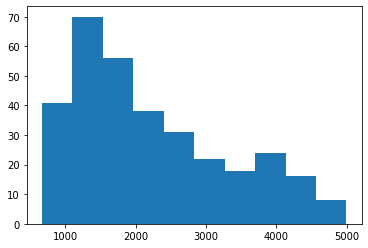

In [ ]:
print(len((ep.metadata.loc[(ep.metadata["rt"]!=0.0) & (ep.metadata["rt"]<5000.0)&(ep.metadata["error"]==0.0),'rt'])))
print(min(ep.metadata.loc[ep.metadata['rt']!=0.0,'rt']))
plt.hist(ep.metadata.loc[(ep.metadata["rt"]!=0.0) & (ep.metadata["rt"]<5000.0)&(ep.metadata["error"]==0.0),'rt'])
plt.show()

In [ ]:

cor_f = []
cor_s = []
sl = [x/10 for x in range(6)]
print(sl)
for i in range(5):
  print(sl[i])
  print(sl[i+1])
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).get_data()
  cor_f += [df.corr()]
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
  cor_s += [df.corr()]
  



[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
0.0
0.1


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.1
0.2


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.2
0.3


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.3
0.4


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


0.4
0.5


<ipython-input-54-58112e2519fe>:9: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 1.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()
<ipython-input-54-58112e2519fe>:11: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  df = ep["error == 0.0"].copy().crop(tmin=sl[i],tmax=sl[i+1]).to_data_frame()


In [ ]:
j_f = [cor_f[x].replace(to_replace=1.0,value=0.0,inplace=False) for x in range(len(cor_f))] 
j_s = [cor_s[x].replace(to_replace=1.0,value=0.0,inplace=False) for x in range(len(cor_s))]
print(jeu)

                   time         epoch  tp'1-tp'2  ...     h3-h4     h4-h5     h8-h9
time       0.000000e+00  4.100132e-18  -0.021002  ... -0.034513 -0.047117  0.001173
epoch      4.100132e-18  0.000000e+00   0.207513  ...  0.097737  0.093916 -0.037951
tp'1-tp'2 -2.100171e-02  2.075129e-01   0.000000  ...  0.033744 -0.047548  0.006026
tp'2-tp'3 -2.575999e-02  1.921106e-01   0.096294  ...  0.013943  0.020689 -0.035950
tp'3-tp'4  6.127708e-02  3.104688e-02   0.131113  ...  0.036887 -0.007110 -0.067056
...                 ...           ...        ...  ...       ...       ...       ...
h1-h2     -7.219948e-02  1.031213e-01  -0.008452  ...  0.318247  0.209157  0.080871
h2-h3     -4.189718e-03  2.359616e-02   0.036579  ...  0.282668  0.033259 -0.028066
h3-h4     -3.451267e-02  9.773681e-02   0.033744  ...  0.000000  0.418069 -0.012527
h4-h5     -4.711744e-02  9.391612e-02  -0.047548  ...  0.418069  0.000000 -0.084020
h8-h9      1.173493e-03 -3.795065e-02   0.006026  ... -0.012527 -0.084020  0

In [ ]:
ma_f = [{x : [y for y in j_f[a][x]] for x in j_f[a].columns} for a in range(len(j_f))]
ma_s = [{x : [y for y in j_s[a][x]] for x in j_s[a].columns} for a in range(len(j_s))]

In [ ]:
li_f = [[(max(ma_f[a][b]),b)for b in ma_f[a].keys()] for a in range(len(ma_f))]
li_s = [[(max(ma_s[a][b]),b)for b in ma_s[a].keys()] for a in range(len(ma_s))]

In [ ]:
sorted(li_s[0],key=lambda a: a[0],reverse=True)


[(0.7661954987469561, "t'4-t'5"),
 (0.7661954987469561, "t'5-t'6"),
 (0.7371069990212991, "ip'11-ip'12"),
 (0.7371069990212991, "ip'12-ip'13"),
 (0.6510781922869467, "t'6-t'7"),
 (0.6410016969144692, "gph'9-gph'10"),
 (0.6410016969144692, "gph'10-gph'11"),
 (0.6083522062030047, "ia'8-ia'9"),
 (0.6083522062030047, "ia'10-ia'11"),
 (0.6081694436416689, "or'10-or'11"),
 (0.6081694436416689, "or'12-or'13"),
 (0.5999979653604157, "or'8-or'9"),
 (0.5999979653604157, "or'9-or'10"),
 (0.5978687909554, "b'6-b'7"),
 (0.5978687909554, "b'7-b'8"),
 (0.5585103231386979, "b'11-b'12"),
 (0.5585103231386979, "b'12-b'13"),
 (0.5529048232205391, "or'7-or'8"),
 (0.5513097532186856, "a'10-a'11"),
 (0.5513097532186856, "a'12-a'13"),
 (0.5383812642013175, 'tb3-tb4'),
 (0.5383812642013175, 'tb4-tb5'),
 (0.5352997647321122, "gph'8-gph'9"),
 (0.5269051190619289, "ia'5-ia'6"),
 (0.5269051190619289, "ia'6-ia'7"),
 (0.5222093261705045, "b'5-b'6"),
 (0.5082968352114643, "pi'4-pi'5"),
 (0.5082968352114643, "pi'6-pi

# 4 - ML

In [ ]:
a = np.arange(27).reshape(3,9)
print(a)
rng = np.random.default_rng()
b = rng.permutation(a,axis=1)
print(b)

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]]
[[ 2  6  5  1  8  3  7  4  0]
 [11 15 14 10 17 12 16 13  9]
 [20 24 23 19 26 21 25 22 18]]


In [ ]:
con = ep.info["ch_names"]

In [ ]:

def Epoch_NBS(ep,con,p=100):
  rng = np.random.default_rng()
  data = [rng.permutation(ep,axis=1) for i in range(p)]
  pper = np.empty((p,len(con),len(con)),dtype=object)
  
  for i in range(len(data)):

    pper[i,:,:] = np.absolute(sts.spearmanr(data[i],axis=1)[0])
    """pper[i,:,:] = [[abs(sts.spearmanr(data[i][a],data[i][b])[0]) for b in range(len(con))] for a in range(len(con))]"""
  
  t_sig = np.array([[abs(sts.spearmanr(ep[a],ep[b])[0]) for b in range(len(con))] for a in range(len(con))])

  G = nx.Graph()
  print(t_sig[0,:])
  for i in range(len(con)):
    
    add = [x for x in range(len(con)) if t_sig[i,x] > np.sort(pper[:,i,x])[math.floor(0.5*p)-1]]
    
    if len(add) == 0:
      pass
    else:
      G.add_edges_from([(con[i],con[x],{"weight":t_sig[i,x]}) for x in add if not con[i] == x])
  return G

In [ ]:

def Epoch_NBS(ep,con,cut,p=100):
  """
  rng = np.random.default_rng()
  data = [rng.permutation(ep,axis=1) for i in range(p)]
  pper = np.empty((p,len(con),len(con)),dtype=object)
  
  for i in range(len(data)):

    pper[i,:,:] = np.absolute(sts.spearmanr(data[i],axis=1)[0])
    pper[i,:,:] = [[abs(sts.spearmanr(data[i][a],data[i][b])[0]) for b in range(len(con))] for a in range(len(con))]
  """
  #t_sig = np.array([[abs(sts.spearmanr(ep[a],ep[b])[0]) for b in range(len(con))] for a in range(len(con))])
  t_sig = np.absolute(sts.spearmanr(ep,axis=1)[0])
  G = nx.Graph()
  print(p)
  for i in range(len(con)):
    
    add = [x for x in range(len(con)) if t_sig[i,x] > cut[i,x]]
    
    if len(add) == 0:
      pass
    else:
      G.add_edges_from([(con[i],con[x],{"weight":t_sig[i,x]}) for x in add if not con[i] == con[x]])
  return G

In [ ]:
print(ep.info["ch_names"])

["tp'1-tp'2", "tp'5-tp'6", "tp'6-tp'7", "tp'7-tp'8", "tp'8-tp'9", "tb'3-tb'4", "tb'4-tb'5", "tb'5-tb'6", "tb'6-tb'7", "tb'7-tb'8", "tb'8-tb'9", "tb'9-tb'10", "tb'10-tb'11", "tb'11-tb'12", "tb'12-tb'13", "a'3-a'4", "a'4-a'5", "a'5-a'6", "a'6-a'7", "a'7-a'8", "a'8-a'9", "b'4-b'5", "b'5-b'6", "b'6-b'7", "b'7-b'8", "b'8-b'9", "b'9-b'10", "b'10-b'11", "b'11-b'12", "b'12-b'13", "gph'4-gph'5", "gph'5-gph'6", "gph'6-gph'7", "gph'7-gph'8", "gph'8-gph'9", "gph'9-gph'10", "t'1-t'2", "t'2-t'3", "t'7-t'8", "h'1-h'2", "h'2-h'3", "h'3-h'4", "h'4-h'5", "h'5-h'6", "h'8-h'9", "h'9-h'10", "h'10-h'11", "h'11-h'12", "or'1-or'2", "or'2-or'3", "or'3-or'4", "or'4-or'5", "or'5-or'6", "or'6-or'7", "or'7-or'8", "or'8-or'9", "or'9-or'10", "or'10-or'11", "or'11-or'12", "or'12-or'13", "or'13-or'14", "of'1-of'2", "of'2-of'3", "of'3-of'4", "of'4-of'5", "of'5-of'6", "of'6-of'7", "of'7-of'8", "of'8-of'9", "of'9-of'10", "of'10-of'11", "of'11-of'12", "of'12-of'13", "of'13-of'14", "ia'1-ia'2", "ia'2-ia'3", "ia'3-ia'4", "i

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
"""
con = ep.info["ch_names"]
# 1) On détermine 200 noeuds qui seront tiré des réseaux erreurs et succès
X_err = [[1 if i in nbg_err[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_err.nodes()],k=1000)]
X_succ = [[1 if i in nbg_succ[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_succ.nodes()],k=1000)]
lab = [1 if x < 1000 else 0 for x in range(2000)]
X= X_err+X_succ

# 2) On fit le svm
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X,lab)

# 3) Est ce que le fit est bon ?
"""

# 3) On génère des données epoch par epoch
rnd = [random.randint(0,np.shape(epraw_err)[0]) for i in range(5)]
g_ep_er = [Epoch_NBS(epraw_err[i,:,:],con,cutoff,p=i) for i in range(np.shape(epraw_err)[0])]
rnd = [random.randint(0,np.shape(epraw_succ)[0]) for i in range(5)]
g_ep_su = [Epoch_NBS(epraw_succ[i,:,:],con,cutoff,p=i) for i in range(np.shape(epraw_succ)[0])]

In [ ]:
for i in g_ep_er:
  for c in nx.connected_components(i):
    print(len(c))

Permutation score =  0.6238095238095238
P_val =  0.009900990099009901
Précision =  0.5714285714285714
Tru neg =  11
Fal pos =  23
Fal neg =  7
Tru pos =  29


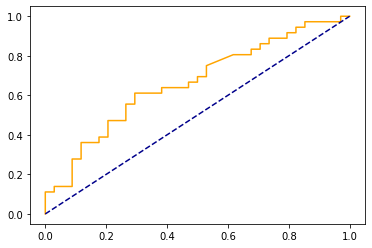

In [ ]:
from sklearn.model_selection import permutation_test_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, balanced_accuracy_score
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

# 1) On détermine 200 noeuds qui seront tiré des réseaux erreurs et succès
#X_err = [[1 if i in nbg_err[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_err.nodes()],k=100)]
#X_succ = [[nbg_err[x][i]["weight"] if i in nbg_succ[x] else 0 for i in con] for x in random.choices([x for x in con if x in nbg_succ.nodes()],k=100)]
X_err = [[nbg_err[x][i]["weight"] if i in nbg_err[x] else 0 for i in con] for x in nbg_err.nodes()]
X_succ = [[nbg_succ[x][i]["weight"] if i in nbg_succ[x] else 0 for i in con] for x in nbg_succ.nodes()]
l = [1 if x < len(X_err) else 0 for x in range(len(X_err)+len(X_succ))]
X= X_err+X_succ

# 2) On fit le svm
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
scal = [1/(len(X[0])*np.var(X))]
gammas += scal
kerns = ('linear','rbf')
parameters = {'kernel':('linear', 'rbf'), 'C':Cs,'gamma':gammas}

#Optimisation des Hyper-paramètres
sv = svm.SVC(probability=True)
clfCV = GridSearchCV(sv,parameters,scoring='balanced_accuracy')
clfCV.fit(X,l)
clf = clfCV.best_estimator_ #Retourne un SVM ayant les meilleurs paramètres trouvé


score, perm, p_val = permutation_test_score(clf,X,l)
print("Permutation score = ",score)
print("P_val = ",p_val)
X_train, X_test, y_train, y_test = train_test_split(X,l,test_size=0.33,random_state=42)
clf.fit(X_train,y_train)
print("Précision = ",accuracy_score(y_test,clf.predict(X_test)))
prec = confusion_matrix(y_test,clf.predict(X_test))
print('Tru neg = ',prec[0][0])
print('Fal pos = ',prec[0][1])
print('Fal neg = ',prec[1][0])
print('Tru pos = ',prec[1][1])

pb = clf.predict_proba(X_test)
pb = pb[:,1]
fper, tper, thersh = roc_curve(y_test,pb)
plt.plot(fper,tper,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.show()

(100, 122)
(1, 122)
(2, 122)
(3, 122)
(4, 122)
(5, 122)
(6, 122)
(7, 122)
(8, 122)
(9, 122)
(10, 122)
(11, 122)
(12, 122)
(13, 122)
(14, 122)
(15, 122)
(16, 122)
(17, 122)
(18, 122)
(19, 122)
(20, 122)
(21, 122)
(22, 122)
(23, 122)
(24, 122)
(25, 122)
(26, 122)
(27, 122)
(28, 122)
(29, 122)
(30, 122)
(31, 122)
(32, 122)
(33, 122)
(34, 122)
(35, 122)
(36, 122)
(37, 122)
(38, 122)
(39, 122)
(40, 122)
(41, 122)
(42, 122)
(43, 122)
(44, 122)
(45, 122)
(46, 122)
(47, 122)
(48, 122)
(49, 122)
(50, 122)
(51, 122)
(52, 122)
(53, 122)
(54, 122)
(55, 122)
(56, 122)
(57, 122)
(58, 122)
(59, 122)
(60, 122)
(61, 122)
(62, 122)
(63, 122)
(64, 122)
(65, 122)
(66, 122)
(67, 122)
(68, 122)
(69, 122)
(70, 122)
(71, 122)
(72, 122)
(73, 122)
(74, 122)
(75, 122)
(76, 122)
(77, 122)
(78, 122)
(79, 122)
(80, 122)
(81, 122)
(82, 122)
(83, 122)
(84, 122)
(85, 122)
(86, 122)
(87, 122)
(88, 122)
(89, 122)
(90, 122)
(91, 122)
(92, 122)
(93, 122)
(94, 122)
(95, 122)
(96, 122)
(97, 122)
(98, 122)
(99, 122)
(100, 12

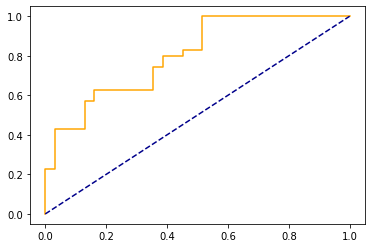

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

nb_comp = 5
nb_ep = 100
nb_node = 100
"""
X_e = np.empty((nb_ep,nb_node*nb_comp))
X_s = np.empty((nb_ep,nb_node*nb_comp))
"""
X_e = []
X_s = []
n_e = []
n_s = []

co_err = {a : [x[0] for x in nbg_err.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_err.nodes.data(data='community')])}
co_succ = {a : [x[0] for x in nbg_succ.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_succ.nodes.data(data='community')])}
c =0
pca = PCA(n_components=nb_comp)
for i in random.choices(range(len(g_ep_er)),k=nb_ep):
  """
  #Variation Community Detection
  #1) On va assigner une communauté à chaque noeud de chaque graph
  vec = []
  louv_clust = louvain(g_ep_er[i],weight='weight')
  com = louv_clust.to_node_community_map()
  nx.set_node_attributes(g_ep_er[i],com,"community")
  co_n = {a : [x[0] for x in g_ep_er[i].nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in g_ep_er[i].nodes.data(data='community')])}
  
  #2) On crée autant de vecteur que de communauté dans lequel, chaque dimension correspond au coefficient de jaccard
  #   Entre cette commauté et celles obtenues par les potentiel évoqués
  
  for i in co_n.keys():
    vec += [[len(set(co_n[i]).intersection(co_err[j]))/len(set(co_n[i]).union(co_err[j])) for j in co_err.keys()] + [len(set(co_n[i]).intersection(co_succ[j]))/len(set(co_n[i]).union(co_succ[j])) for j in co_succ.keys()]]
  X_e += vec
  """
  #Variation PageRank
  
  it = nx.clustering(g_ep_er[i])
  X_e += [[it[x] if x in g_ep_er[i].nodes() else 0 for x in con]]
  

  #Variation Poids, le n_e était pour voir s'il y avait des noeuds qui permettaient de mieux prédire ou pas
  """
  node = random.choices([x for x in con if x in g_ep_er[i].nodes()],k=50)
  X_e += [[g_ep_er[i][x][j]["weight"] if j in g_ep_er[i][x] else 0 for j in con] for x in node]
  n_e += node
  """
  
  #Variation vecteur binaire d'adjacence
  #X_e += [[1 if j in g_ep_er[i][x] else 0 for j in con] for x in g_ep_er[i].nodes()]

  #Variation Poids + t-SNE
  """
  node = random.choices([x for x in con if x in g_ep_er[i].nodes()],k=nb_node)
  #emb = TSNE(n_components=nb_comp).fit_transform([[g_ep_er[i][x][j]["weight"] if j in g_ep_er[i][x] else 0 for j in con] for x in node])
  emb = pca.fit_transform([[1 if j in g_ep_er[i][x] else 0 for j in con] for x in node])
  print(np.shape(emb))
  X_e[c,:] = np.reshape(emb,(np.shape(emb)[0]*np.shape(emb)[1]))
  c+=1
  """
print(np.shape(X_e))
c=0
for i in random.choices(range(len(g_ep_su)),k=nb_ep):
  """
  vec = []
  #Variation Community Detection
  #1) On va assigner une communauté à chaque noeud de chaque graph
  louv_clust = louvain(g_ep_su[i],weight='weight')
  com = louv_clust.to_node_community_map()
  nx.set_node_attributes(g_ep_su[i],com,"community")
  co_n = {a : [x[0] for x in g_ep_su[i].nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in g_ep_su[i].nodes.data(data='community')])}
  
  #2) On crée autant de vecteur que de communauté dans lequel, chaque dimension correspond au coefficient de jaccard
  #   Entre cette commauté et celles obtenues par les potentiel évoqués
  for i in co_n.keys():
    vec += [[len(set(co_n[i]).intersection(co_err[j]))/len(set(co_n[i]).union(co_err[j])) for j in co_err.keys()] + [len(set(co_n[i]).intersection(co_succ[j]))/len(set(co_n[i]).union(co_succ[j])) for j in co_succ.keys()]]
  X_s += vec
  """
  #Variation PageRank
  
  it = nx.clustering(g_ep_su[i])
  X_s += [[it[x] if x in g_ep_su[i].nodes() else 0 for x in con]]
  print(np.shape(X_s))
  
  #Variation vecteur binaire d'adjacence
  #X_s += [[1 if j in g_ep_su[i][x] else 0 for j in con] for x in g_ep_su[i].nodes()]

  #Variation Poids, le n_e était pour voir s'il y avait des noeuds qui permettaient de mieux prédire ou pas
  """
  node = random.choices([x for x in con if x in g_ep_su[i].nodes()],k=50)
  X_s += [[g_ep_su[i][x][j]["weight"] if j in g_ep_su[i][x] else 0 for j in con] for x in node]
  n_s += node
  """

  #Variation Poids + t-SNE
  """
  node = random.choices([x for x in con if x in g_ep_su[i].nodes()],k=nb_node)
  #emb = TSNE(n_components=nb_comp).fit_transform([[g_ep_su[i][x][j]["weight"] if j in g_ep_su[i][x] else 0 for j in con] for x in node])
  emb = pca.fit_transform([[1 if j in g_ep_su[i][x] else 0 for j in con] for x in node])
  X_s[c,:] = np.reshape(emb,(np.shape(emb)[0]*np.shape(emb)[1]))
  c+=1
  """
X = np.concatenate((X_e,X_s))
print(np.shape(X))
l = [1 if x < len(X_e) else 0 for x in range(len(X))]
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
N = n_e+n_s

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
scal = [1/(len(X[0])*np.var(X))]
gammas += scal
kerns = ('linear','rbf')
parameters = {'kernel':('linear', 'rbf'), 'C':Cs,'gamma':gammas}

#Optimisation des Hyper-paramètres
sv = svm.SVC(probability=True)
clfCV = GridSearchCV(sv,parameters,scoring='balanced_accuracy')
clfCV.fit(X,l)
clf = clfCV.best_estimator_ #Retourne un SVM ayant les meilleurs paramètres trouvé
      

score, perm, p_val = permutation_test_score(clf,X,l,scoring="balanced_accuracy")
print("Précision = ",score)
print("P_val = ",p_val)

X_train, X_test, y_train, y_test = train_test_split(X,l,test_size=0.33,random_state=42)
clf.fit(X_train,y_train)
print("Précision = ",balanced_accuracy_score(y_test,clf.predict(X_test)))
prec = confusion_matrix(y_test,clf.predict(X_test))
print('Tru neg = ',prec[0][0])
print('Fal pos = ',prec[0][1])
print('Fal neg = ',prec[1][0])
print('Tru pos = ',prec[1][1])

pb = clf.predict_proba(X_test)
pb = pb[:,1]
fper, tper, thersh = roc_curve(y_test,pb)
plt.plot(fper,tper,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.show()



In [ ]:
pb = clf.predict_proba(X_test)
pb = pb[:,1]
fper, tper, thersh = roc_curve(y_test,pb)
plt.plot(fper,tper,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
plt.savefig("roc_pagerank_unbalanced_450vecteur.png")

In [ ]:
from cdlib.algorithms import louvain
from cdlib.viz import plot_network_clusters

louv_clust = louvain(nbg_err,weight='weight')
com = louv_clust.to_node_community_map()
nx.set_node_attributes(nbg_err,com,"community")
print(nbg_err.nodes.data(data="community"))

co_err = {a : [x[0] for x in nbg_err.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_err.nodes.data(data='community')])}

louv_clust = louvain(nbg_succ,weight='weight')
com = louv_clust.to_node_community_map()
nx.set_node_attributes(nbg_succ,com,"community")
print(nbg_succ.nodes.data(data="community"))

co_succ = {a : [x[0] for x in nbg_succ.nodes.data(data='community') if x[1][0] == a] for a in set([x[1][0] for x in nbg_succ.nodes.data(data='community')])}

ke = []
vec = [[len(set(co_succ[i]).intersection(co_err[j]))/len(set(co_succ[i]).union(co_err[j])) for j in co_err.keys()] for i in co_succ.keys()]
vec += [[len(set(co_succ[i]).intersection(co_succ[j]))/len(set(co_succ[i]).union(co_succ[j])) for j in co_succ.keys()] for i in co_succ.keys()]
for i in vec:
  print(i)
#jacc = [[set(co_succ[i] for j in co_err.keys()+co_succ.keys())] for i in co_succ.keys()]

[("tp'1-tp'2", [2]), ("t'1-t'2", [2]), ("h'1-h'2", [0]), ("ia'2-ia'3", [2]), ("tp'5-tp'6", [2]), ("tp'6-tp'7", [4]), ("tb'4-tb'5", [4]), ("of'1-of'2", [4]), ("tp'7-tp'8", [1]), ("b'6-b'7", [1]), ("pi'14-pi'15", [1]), ("tp'8-tp'9", [4]), ("tb'8-tb'9", [0]), ('tb2-tb3', [4]), ("tb'3-tb'4", [0]), ("pi'10-pi'11", [0]), ("of'6-of'7", [1]), ("tb'6-tb'7", [9]), ('b4-b5', [9]), ("tb'7-tb'8", [2]), ("ip'2-ip'3", [2]), ("ip'3-ip'4", [3]), ("pi'11-pi'12", [2]), ('b7-b8', [2]), ("a'8-a'9", [0]), ("or'9-or'10", [0]), ("of'12-of'13", [0]), ("of'13-of'14", [0]), ("ia'10-ia'11", [0]), ('tb9-tb10', [0]), ('h2-h3', [0]), ("tb'9-tb'10", [0]), ("gph'9-gph'10", [0]), ('b1-b2', [0]), ('b3-b4', [0]), ('b11-b12', [0]), ("tb'10-tb'11", [1]), ("t'7-t'8", [1]), ("tb'11-tb'12", [3]), ("or'8-or'9", [3]), ("or'12-or'13", [3]), ("tb'12-tb'13", [2]), ("a'3-a'4", [5]), ("t'2-t'3", [5]), ("ia'8-ia'9", [5]), ('h8-h9', [5]), ("a'4-a'5", [6]), ("b'9-b'10", [6]), ("a'5-a'6", [5]), ("a'6-a'7", [2]), ("gph'5-gph'6", [2]), ("